In [8]:
import pandas as pd
import plotly

# Read the CSV filed
df = pd.read_excel('./data/ubnb_data.xlsx')  # Assuming tab-separated based on your image


In [14]:
# Import the model
from hbv_model import HBVModel
from calibration import calibrate_hbv_model  # function to do the calibration
import pandas as pd


# 1. Initialize the model
model = HBVModel()

# # 2. Load your data (either from file or DataFrame)
# # Read the data from pandas df
model.load_data(data=df,
               date_column='Date',
               precip_column='Precipitation',
               temp_column='Temperature',
               pet_column='PET',
               obs_q_column='Qobs',
               date_format='%Y%m%d')
            #    start_date='1984-01-15',          # start date you want
            #    end_date='1992-01-15',
            # )  # if you have observed discharge




Time step detected: D
Loaded data with 9117 time steps, from 1981-01-15 00:00:00 to 2005-12-31 00:00:00


In [15]:
import matplotlib.pyplot as plt 
model.data

,Date,Qsim,Qobs,Precipitation,Temperature,AET,PET,Snow,Snowcover,SM,Recharge,SUZ,SLZ,Q0,Q1,Q2,Unnamed: 16,Unnamed: 17,calibration,SubCatchment_1
0,1981-01-15,0.104,0.103,0.1,21.9,0.24,0.24,0,0,348511.0,0.0,0.0,4.2,0.0,0.000,0.104,NaN,NaN,Water Balance [mm/year]:,NaN
1,1981-01-16,0.107,0.100,0.1,21.9,0.24,0.24,0,0,348510.8,0.0,0.0,4.1,0.0,0.000,0.107,NaN,NaN,Sum Qsim,289.465962
2,1981-01-17,0.110,0.099,0.0,21.9,0.24,0.24,0,0,348510.6,0.0,0.0,4.0,0.0,0.000,0.110,NaN,NaN,Sum Qobs,252.337962
3,1981-01-18,0.111,0.099,0.5,21.9,0.24,0.24,0,0,348510.7,0.1,0.0,4.0,0.0,0.000,0.111,NaN,NaN,Sum Precipitation,1148.833196
4,1981-01-19,0.111,0.096,0.5,21.9,0.24,0.24,0,0,348510.8,0.1,0.0,4.0,0.0,0.000,0.111,NaN,NaN,Sum AET,86.749800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9112,2005-12-27,0.410,0.165,0.0,21.5,0.24,0.24,0,0,367798.7,0.0,0.0,14.1,0.0,0.006,0.405,NaN,NaN,NaN,NaN
9113,2005-12-28,0.403,0.205,0.0,21.8,0.24,0.24,0,0,367798.4,0.0,0.0,13.8,0.0,0.004,0.399,NaN,NaN,NaN,NaN
9114,2005-12-29,0.395,0.165,0.0,21.5,0.24,0.24,0,0,367798.2,0.0,0.0,13.5,0.0,0.003,0.393,NaN,NaN,NaN,NaN
9115,2005-12-30,0.387,0.170,0.5,21.5,0.24,0.24,0,0,367798.3,0.1,0.0,13.3,0.0,0.002,0.386,NaN,NaN,NaN,NaN


In [24]:

custom_params = {
    'snow': {
        'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},      # Temperature threshold for snow/rain (°C)
        'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4},      # Degree-day factor (mm/°C/day)
        'PCF': {'min': 0.65, 'max': 1.0, 'default': 0.67},      # Precipitation correction factor (-)
        'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},     # Snowfall correction factor (-)
        'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},     # Refreezing coefficient (-)
        'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}       # Water holding capacity of snow (-)
    },
    'soil': {
        'FC': {'min': 10, 'max': 30, 'default': 25},  # Field capacity (mm)
        'LP': {'min': 0.3, 'max': 1.0, 'default': 0.75},      # Limit for potential evaporation (-)
        'BETA': {'min': 1.0, 'max': 35, 'default': 3.0}      # Shape coefficient (-)
    },
    'response': {
        'K0': {'min': 0.001, 'max': 0.1, 'default': 0.015},      # Quick flow recession coefficient (1/day)
        'K1': {'min': 0.000005, 'max': 0.00005, 'default': 0.000005},     # Intermediate flow recession coefficient (1/day)
        'K2': {'min': 0.0000005, 'max': 0.000005, 'default': 0.000005},     # Baseflow recession coefficient (1/day)
        'UZL': {'min': 1, 'max': 4, 'default': 1.5},    # Upper zone threshold (mm)
        'PERC': {'min': 1, 'max': 7, 'default': 4.6}     # Percolation rate (mm/day)
    }
}
model.set_parameters(custom_params)

#4. Set initial conditions (optional - uses defaults if not set)
model.set_initial_conditions(
    snowpack=0,  #initial snowpack (mm)
    liquid_water=0,    # Initial liquid water in snow (mm)
    soil_moisture= 650,  # Initial soil moisture (mm)
    upper_storage=80,   # Initial upper zone storage (mm)
    lower_storage=30, ) # Initial lower zone storage (mm)

# 5. Run the model
results = model.run()

Initial conditions updated.
Starting model run for 9117 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -1.224
KGE: -1.631
PBIAS: -67.1%
Correlation: 0.136


In [21]:
#6. Visualize results
# model.plot_results(output_file='fig.png')

#7. Save results to CSV (optional)
#model.save_results("./results/hbv_uncalibrated_results.csv")

Starting calibration using L-BFGS-B method...
Optimizing NSE with 14 parameters and 500000000 iterations
Starting model run for 9117 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.081
KGE: 0.278
PBIAS: -68.1%
Correlation: 0.840
Starting model run for 9117 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.081
KGE: 0.278
PBIAS: -68.1%
Correlation: 0.840
Starting model run for 9117 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.081
KGE: 0.278
PBIAS: -68.1%
Correlation: 0.840
Starting model run for 9117 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.081
KGE: 0.278
PBIAS: -68.1%
Correlation: 0.840
Starting model run for 9117 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.081
KGE: 0.278
PBIAS: -68.1%
Correlation: 0.840
Starting model run for 9117 time steps...
Model run completed successfully!
Perf

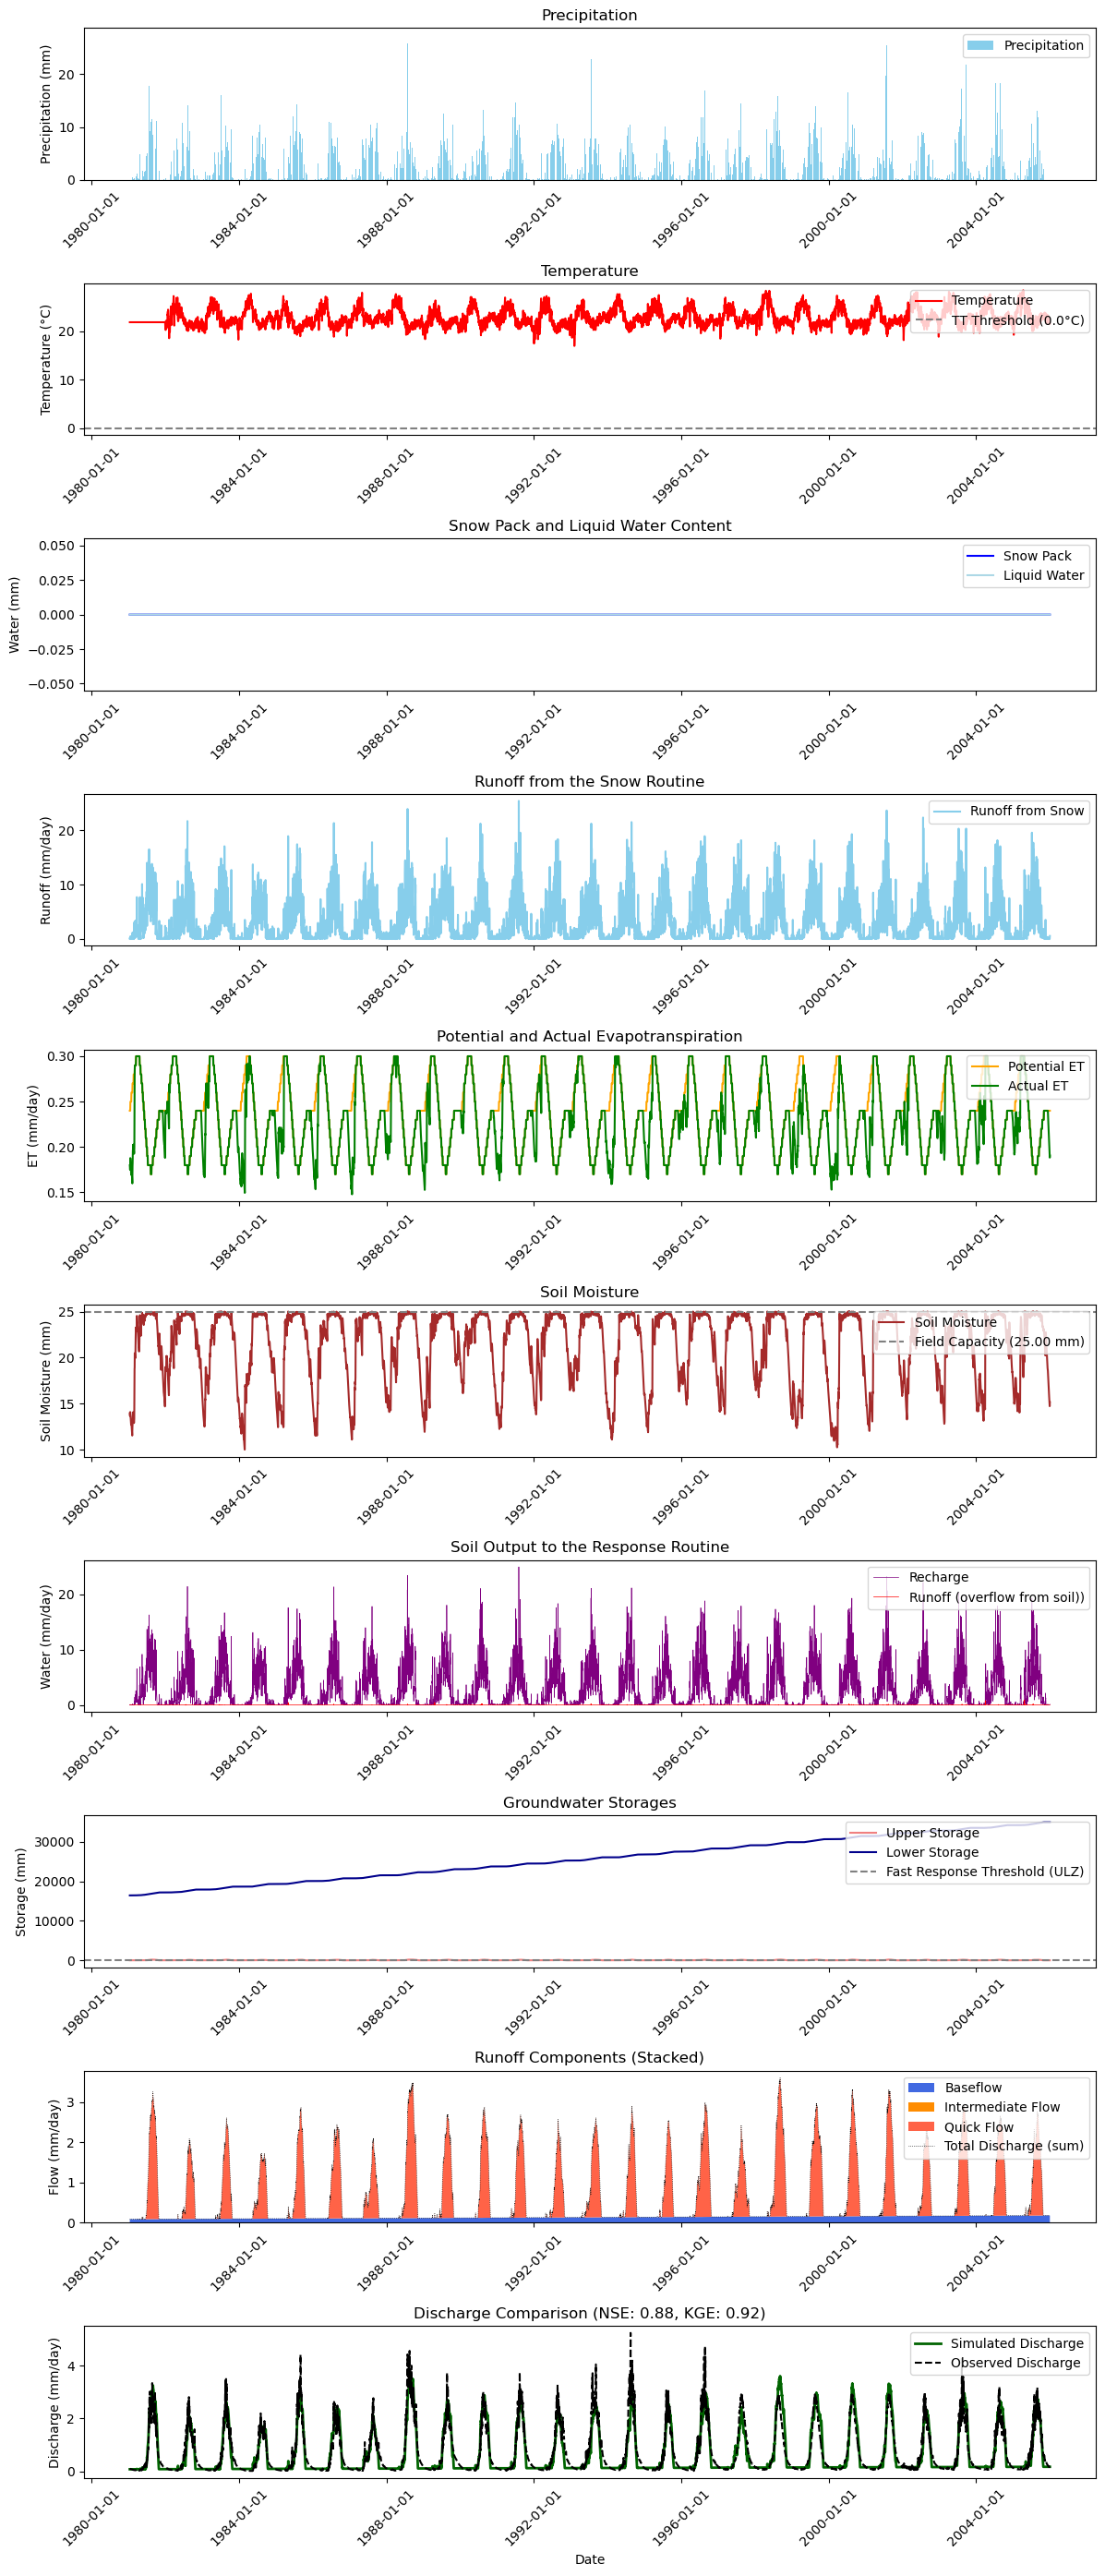

In [25]:
results = calibrate_hbv_model(
    model,
    method='L-BFGS-B',     # Optimization algorithm——Options include 'SLSQP', 'L-BFGS-B', 'Nelder-Mead', etc.
    objective='NSE',    # Objective function to optimize
    iterations=500000000,     # Maximum iterations
    verbose=True,       # Print progress
    plot_results=True   # Plot results after calibration
)

# The model now has calibrated parameters
# You can access them via model.params

# You can also access the calibration results
optimized_params = results['parameters']
performance = results['performance']
optimization_details = results['optimization_result']


In [26]:
cal_par= model.params
cal_par

{'response': {'K0': {'min': 0.001,
   'max': 0.1,
   'default': 0.017928309254250915},
  'K1': {'min': 5e-06, 'max': 5e-05, 'default': 5.0004427280349905e-06},
  'K2': {'min': 5e-07, 'max': 5e-06, 'default': 5e-06},
  'UZL': {'min': 1, 'max': 4, 'default': 1.494382401198882},
  'PERC': {'min': 1, 'max': 7, 'default': 4.287418116492705}},
 'soil': {'FC': {'min': 10, 'max': 30, 'default': 24.99995429108948},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7511074936130249},
  'BETA': {'min': 1.0, 'max': 35, 'default': 3.0001846960034175}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4.0},
  'PCF': {'min': 0.65, 'max': 1.0, 'default': 0.9273536670591036},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}}}

In [30]:
performance

{'NSE': 0.9126435653586553,
 'KGE': 0.8823810664350796,
 'PBIAS': 5.067602733997094,
 'r': 0.9577550413049972}

In [ ]:
custom_params_UBNB ={'response': {'K0': {'min': 0.001,
   'max': 0.1,
   'default': 0.017928309254250915},
  'K1': {'min': 5e-06, 'max': 5e-05, 'default': 5.0004427280349905e-06},
  'K2': {'min': 5e-07, 'max': 5e-06, 'default': 5e-06},
  'UZL': {'min': 1, 'max': 4, 'default': 1.494382401198882},
  'PERC': {'min': 1, 'max': 7, 'default': 4.287418116492705}},
 'soil': {'FC': {'min': 10, 'max': 30, 'default': 24.99995429108948},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7511074936130249},
  'BETA': {'min': 1.0, 'max': 35, 'default': 3.0001846960034175}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4.0},
  'PCF': {'min': 0.65, 'max': 1.0, 'default': 0.9273536670591036},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}}}
custom_params_lookout = {
    'snow': {
        'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},      # Temperature threshold for snow/rain (°C)
        'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4},      # Degree-day factor (mm/°C/day)
        'PCF': {'min': 0.65, 'max': 1.0, 'default': 0.67},      # Precipitation correction factor (-)
        'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},     # Snowfall correction factor (-)
        'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},     # Refreezing coefficient (-)
        'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}       # Water holding capacity of snow (-)
    },
    'soil': {
        'FC': {'min': 50.0, 'max': 650, 'default': 450.0},  # Field capacity (mm)
        'LP': {'min': 0.3, 'max': 1.0, 'default': 0.75},      # Limit for potential evaporation (-)
        'BETA': {'min': 1.0, 'max': 35, 'default': 3.0}      # Shape coefficient (-)
    },
    'response': {
        'K0': {'min': 0.01, 'max': 0.9, 'default': 0.12},      # Quick flow recession coefficient (1/day)
        'K1': {'min': 0.05, 'max': 0.5, 'default': 0.05},     # Intermediate flow recession coefficient (1/day)
        'K2': {'min': 0.005, 'max': 0.5, 'default': 0.05},     # Baseflow recession coefficient (1/day)
        'UZL': {'min': 5.0, 'max': 50.0, 'default': 28.0},    # Upper zone threshold (mm)
        'PERC': {'min': 0.03, 'max': 25, 'default': 0.25}     # Percolation rate (mm/day)
    }
}

custom_params_HBV_land ={'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.11323336086000878},
  'K1': {'min': 0.005, 'max': 0.5, 'default': 0.0646675395143037},
  'K2': {'min': 0.0005, 'max': 0.5, 'default': 0.018321217741902936},
  'UZL': {'min': 5.0, 'max': 50.0, 'default': 26.61999369079226},
  'PERC': {'min': 0.03, 'max': 25, 'default': 0.03}},
 'soil': {'FC': {'min': 50.0, 'max': 650, 'default': 449.7368169438645},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7745757831402357},
  'BETA': {'min': 1.0, 'max': 35, 'default': 3.3155189242761236}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': -1.099975575374229},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 6.0},
  'PCF': {'min': 0.65, 'max': 1.0, 'default': 1.0},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 1.0368534489917745},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.06867576949957854},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.08436634612318128}}}